In [1]:
import pandas as pd
from pandas.api import types

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

**DATA COLLECTION**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/MyDrive/Tugas pacmann/mlcases/TRAIN_Supplement_sales_pred.csv")
test = pd.read_csv("/content/drive/MyDrive/Tugas pacmann/mlcases/TEST_Supplement_sales_pred.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [5]:
# switch date to datetime pandas
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

#We want to process this train data in order because it is a time series data
train.sort_values(by=['Date'], ignore_index=True, inplace=True)
test.sort_values(by=['Date'], ignore_index=True, inplace=True)

# EDA

**EXPLORATORY DATA ANALYS**

In [ ]:
example = train[train['Store_id']==30].copy()
example['Date'] = example['Date'].apply(pd.to_datetime)
example.set_index('Date', inplace=True)
example.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales
Date,,,,,,,,,
2018-01-01,T1000241,30,S1,L2,R2,1,Yes,38,27322.11
2018-01-02,T1000607,30,S1,L2,R2,0,Yes,66,53952.00
2018-01-03,T1001065,30,S1,L2,R2,0,Yes,60,51000.00
2018-01-04,T1001451,30,S1,L2,R2,0,Yes,66,59304.00
2018-01-05,T1001613,30,S1,L2,R2,0,Yes,75,67497.00


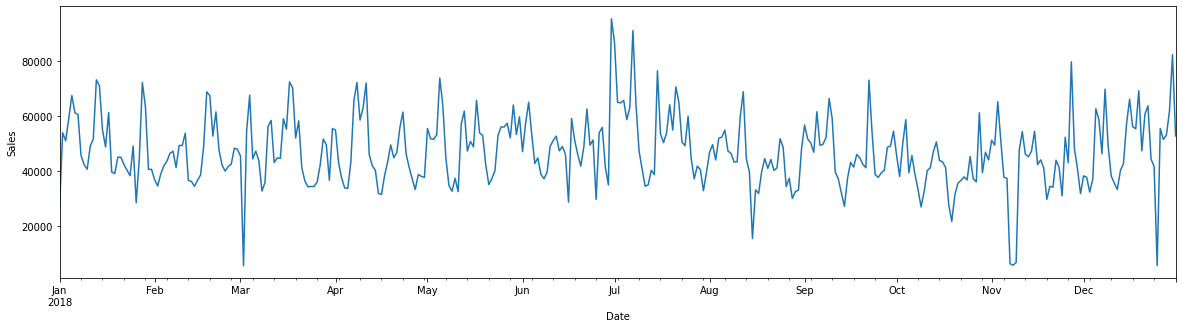

In [ ]:
plt.figure(figsize=(20,5))
ax = example.loc['2018', 'Sales'].plot()
ax.set_ylabel('Sales');

[Text(0, 0.5, 'Sales')]

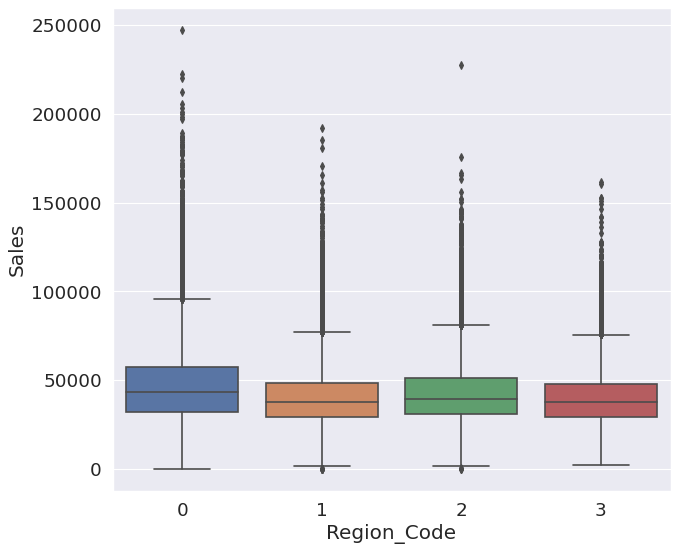

In [ ]:
# Region Code vs Sales
plt.figure(figsize=(9, 8), dpi=80)
sns.set(font_scale = 1.5)
ax = sns.boxplot(x=train["Region_Code"], y=train['Sales'])
ax.set(ylabel = "Sales")

[Text(0, 0.5, 'Sales')]

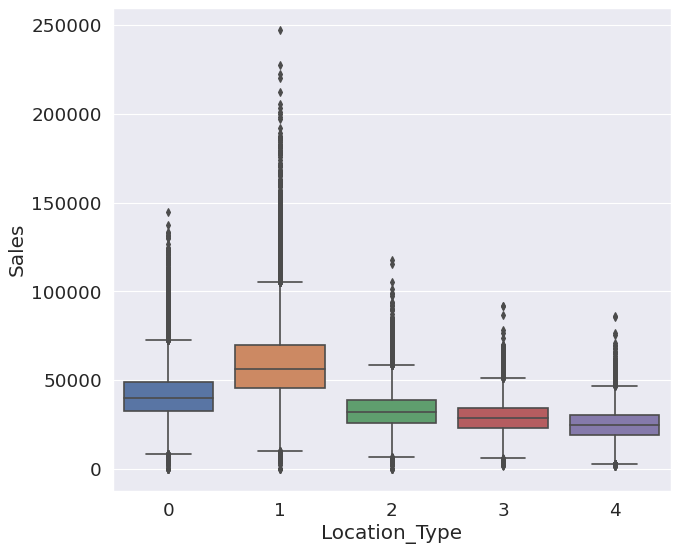

In [ ]:
# Location Type vs Sales
plt.figure(figsize=(9, 8), dpi=80)
sns.set(font_scale = 1.5)
ax = sns.boxplot(x=train["Location_Type"], y=train['Sales'])
ax.set(ylabel = "Sales")

[Text(0, 0.5, 'Sales')]

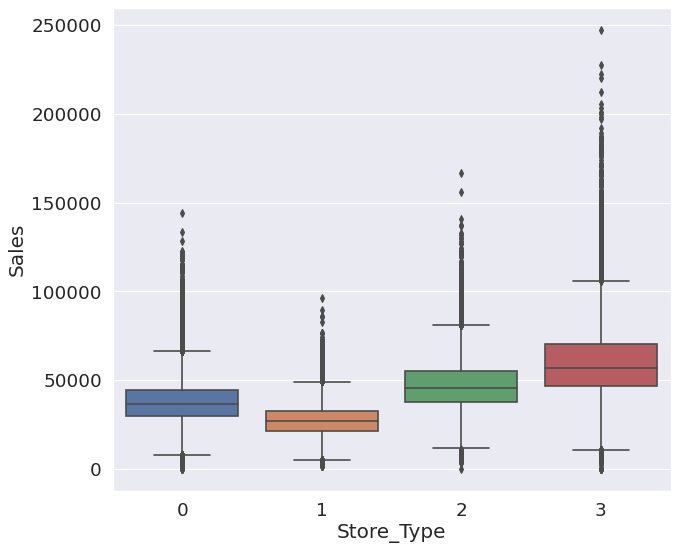

In [ ]:
# Store Type vs Sales
plt.figure(figsize=(9, 8), dpi=80)
sns.set(font_scale = 1.5)
ax = sns.boxplot(x=train["Store_Type"], y=train['Sales'])
ax.set(ylabel = "Sales")

[Text(0, 0.5, 'Sales')]

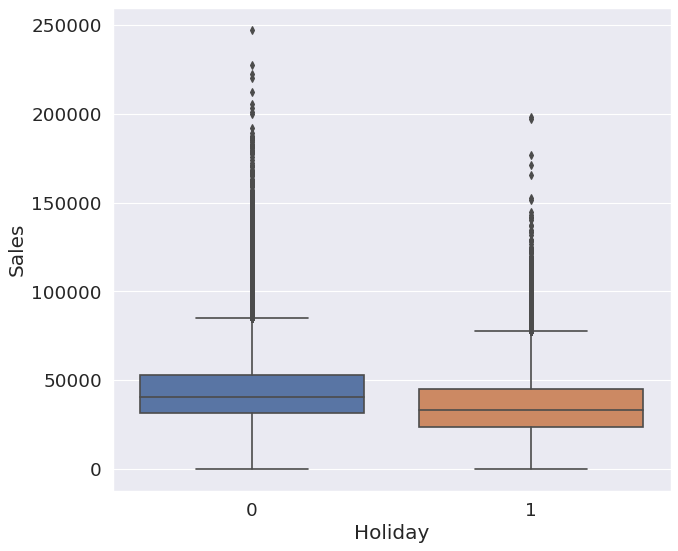

In [ ]:
# Holiday vs Sales
plt.figure(figsize=(9, 8), dpi=80)
sns.set(font_scale = 1.5)
ax = sns.boxplot(x=train["Holiday"], y=train['Sales'])
ax.set(ylabel = "Sales")

[Text(0, 0.5, 'Sales')]

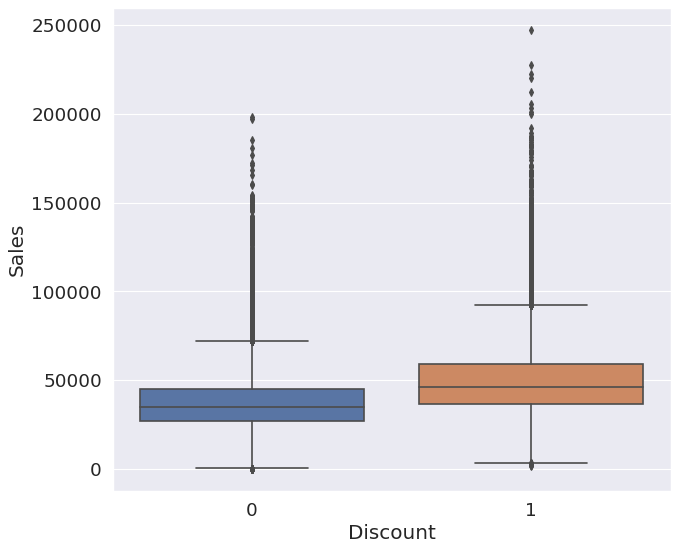

In [ ]:
# Discount vs Sales
plt.figure(figsize=(9, 8), dpi=80)
sns.set(font_scale = 1.5)
ax = sns.boxplot(x=train["Discount"], y=train['Sales'])
ax.set(ylabel = "Sales")

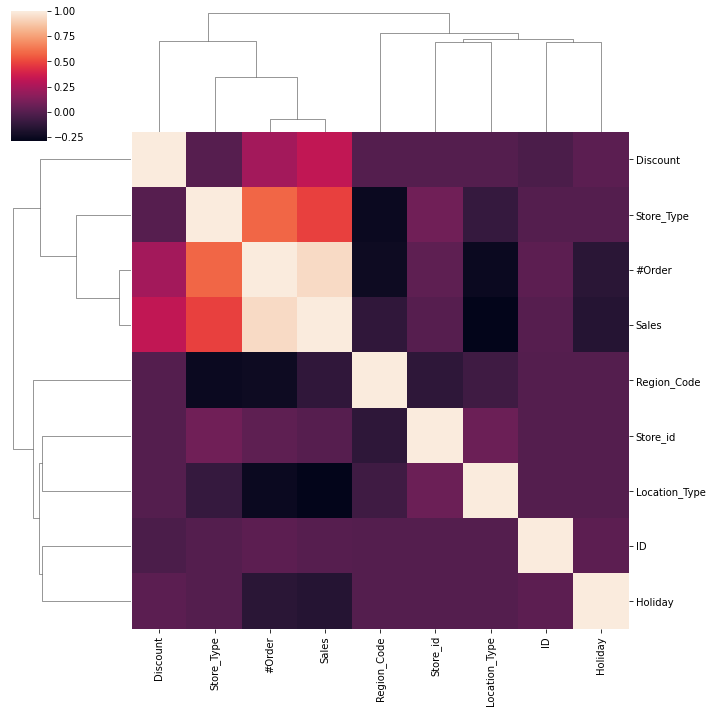

In [ ]:
sns.clustermap(train.corr())

# Machine Learning

**PREPOCESSING DATA**

In [6]:
#We use label encoding to transform data type object here
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for i in train.columns:
    if train[i].dtype == 'object':
        le.fit_transform(list(train[i].values))
        train[i] = le.transform(train[i].values)


for j in train.columns:
    if train[j].dtype == 'object':
        le.fit_transform(list(train[j].values))
        train[j] = le.transform(train[j].values)

In [7]:
#preprocessing data test
for k in test.columns:
    if test[k].dtype == 'object':
        le.fit_transform(list(test[k].values))
        test[k] = le.transform(test[k].values)

In [8]:
# Remove features that we dont want
# We remove the #Order feature because we dont have that in test data

X = train.drop(columns=['ID', 'Sales', '#Order', 'Date'])
y = train['Sales']
X_test_forcast = test.drop(columns=['ID', 'Date'])

# We use Time Series Split instead of Train Split test, because we want our date to keep in order
# Since our data test unlabeled, we use data validation to cross validate
# Time series split also has fold validation that we could set as we need

ts_cv = TimeSeriesSplit(
    n_splits=5,
    max_train_size=None,
)

all_splits = list(ts_cv.split(X, y))

# This data set that we will you us on ML training
train_4, test_4 = all_splits[4]

# Because our data is time series, we also need in order
X_train = X.iloc[train_4]
y_train = y.iloc[train_4]
X_test = X.iloc[test_4]
y_test = y.iloc[test_4]

In [9]:
# This is the result of Time Series Split's

for i in all_splits:
    for j in i:
        d = j.shape
        print(d)

(31390,)
(31390,)
(62780,)
(31390,)
(94170,)
(31390,)
(125560,)
(31390,)
(156950,)
(31390,)



**ML TRAINING**

We used model selection to compare every model and choose the highest score

In [22]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = []
models.append(('RFC', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('LN', LinearRegression()))
models.append(('XGB', XGBRegressor()))

# evaluate each model in turn
results = []
names = []
scoring = 'r2'
for name, model in models:
    #kfold = model_selection.KFold(n_splits=5, shuffle=False)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=ts_cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RFC: 0.654460 (0.037973)
KNN: 0.546639 (0.037295)
CART: 0.654574 (0.037942)
LN: 0.431829 (0.024069)
[05:00:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 0.599154 (0.031467)


Frome the result above, we could look that random forrest has the best score, so we're going to Hyperparameter tuning

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


# define model
model = RandomForestRegressor()

# define search params
params = {'n_estimators' : [5,20,50,100],
          'max_features' : ['auto', 'sqrt'],
          'max_depth' : [int(x) for x in np.linspace(10, 120, num = 12)],
          'min_samples_split' : [2, 6, 10],
          'min_samples_leaf' : [1, 3, 4],
          'bootstrap' : [True, False]}

# define search
search = RandomizedSearchCV(model, params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=ts_cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -7561.279768883664
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}


In [24]:
#Our Score

from sklearn.metrics import r2_score
y_pred = search.predict(X_train)

print(r2_score(y_train, y_pred))

0.6715304255103522


In [25]:
# Our score on test 

y_pred_test = search.predict(X_test)

print(r2_score(y_test, y_pred_test))

0.594177229224615
